# Sentiment Analysis with CNNs

**CS4641 Spring 2020 Final Project**

By: Baran Usluel, Sylesh K Suresh, Kenneth William Wardlaw, Vietfu Tang, Yash Raghavendra Vaidya

## Preparing Data

In [1]:
# If using colab:
# Mounts google drive folder. 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import gensim.models.keyedvectors as word2vec

##########################################
# READ ME:
# If you get a 'No such file' error when you run this, go to your Google Drive,
# find the ML Project folder under Shared With Me, right-click and select
# Add Shortcut To Drive. This makes the 'My Drive/ML Project' path accessible.
##########################################

DATA_DIRECTORY = "gdrive/My Drive/ML Project/scaledata"
WORD2VEC_PATH = "gdrive/My Drive/ML Project/GoogleNews-vectors-negative300.bin.gz"

print("Loading word2vec...")
w2v = word2vec.KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)
print("Done!")

Loading word2vec...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Done!


In [2]:
print("Reading data...")
import random
maxLength = 500 # max words per review
X = []
y = []

least_meaningful_words = {}
#least_meaningful_words = {'the', ',', '.', 'of', 'a', 'and', 'is', 'to', 'in', 'it', 'that', 'as', 'with', 'for', '"', 'but', 'film', 'are', 'this', 'an', 'be', 'not', ':', 'his', 'one', 'by', 'on', 'more', 'has', 'movie', 'you', 'have', "it's", 'he', 'its', '*', 'than', 'from', 'most', 'at', '(', ')', 'i', 'story', 'about', 'all', 'or', 'like', 'which', 'there', 'who', 'much', '--', 'so', 'would', 'they', 'their', 'some', 'what', 'her', 'when', 'too', 'into', 'director', 'time', 'will', 'was', 'even', 'characters', 'picture', 'many', 'up', 'films', 'if', 'little', 'best', 'can', 'no', 'we', 'been', 'just', 'how', 'see', 'character', 'good', 'those', 'while', 'out', 'show', 'although', 'life', 'never', 'way', 'performance', 'does', 'two', 'them', 'only', 'my', "doesn't", 'because', 'may', "there's", 'first', 'enough', 'do', 'us', 'she', 'scenes', 'other', 'love', 'well', 'both', "isn't", 'also', 'part', '=', 'great', 'makes', 'such', 'between', "don't", 'any', 'these', 'few', 'bad', 'make', 'still', 'had', 'work', 'people', 'script', 'could', 'your', 'rated', ';', 'without', 'fine', 'better', 'look', 'audience', 'very', 'cast', 'something', 'music', 'comedy', 'through', 'plot', 'movies', 'however', 'quite', 'scene', 'real', 'him', 'motion', 'role', 'me', 'might', 'seems', 'almost', "film's", '?', 'sense', 'kind', 'screen', 'though', 'being', 'often', 'world', 'moments', 'less', 'where', 'humor', 'ever', 'here', 'every', 'were', 'get', 'screenplay', 'acting', 'over', 'made', 'since', 'always', 'john', 'takes', 'action', 'lot', 'violence', 'yet', "that's", 'interesting', 'gives', 'feel', 'own', 'long', 'comes', 'around', 'really', 'rather'}
for root, _, filelist in os.walk(DATA_DIRECTORY):
    if len(filelist) <= 1:
        continue
    f = open(os.path.join(root, [fi for fi in filelist if fi.startswith('subj')][0]))
    data = []
    for line in f:
        feature = np.zeros((maxLength, 300))
        index = 0
        for word in line.lower().split():
            # TODO: pre-processing (remove non-letter characters, etc.)?
            if index >= maxLength:
                break
            if word not in least_meaningful_words and word in w2v:
                feature[index] = w2v[word]
                index += 1
        data.append(feature)

    label = [int(line) for line in open(os.path.join(root, [f for f in filelist if f.startswith('label.3class')][0]))]
    X += data
    y += label

y = np.array(y)
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
# TODO: can try to use k-fold cross-validation on the training and validation splits

# y can take on values [0,1,2] so 3 classes:
num_classes = y_train.max() + 1

print(X_train.shape)
print(y_train.shape)
print("Done!")

Reading data...
(3003, 500, 300)
(3003,)
Done!


## Build Model & Train

This defines the model and trains it. Skip to the Testing section below if using a presaved version of the model.

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2

# define model
model = Sequential()
model.add(Dropout(0.2, input_shape=(maxLength, 300))) # using dropout on input layer for overfitting
model.add(Conv1D(input_shape=(maxLength, 300), filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Flatten())
# using regularization on dense layer for overfitting -- don't use on conv layers, doesn't seem to work well
model.add(Dense(128, activation='relu', 
                kernel_regularizer=l2(0.04), bias_regularizer=l2(0.04)))
#model.add(Dropout(0.2)) # using dropout between final hidden layers for overfitting
model.add(Dense(num_classes, activation='softmax',
                kernel_regularizer=l2(0.04), bias_regularizer=l2(0.04)))

print(model.summary())

# stops training after validation accuracy stops improving, to avoid overfitting and wasting time
early_stopping = EarlyStopping(min_delta = 0.0001, monitor='val_loss',
                               patience = 4, restore_best_weights=True)
callback = [early_stopping]

# be careful when tuning these hyperparameters, gets screwed up easily.
# Best values found so far (let's keep a log):
# 1) Test accuracy around 70%: Adam with lr=0.0002  as of 4/20/20   - Baran (also changed architecture)
# 2) Test accuracy around 70%: Adam with lr=0.001   as of 4/12/20   - Baran
# 3) Test accuracy around 65%: SGD with lr=0.08, decay=0.05, momentum=0.9    as of 4/12/20   - Baran

adam = Adam(learning_rate=0.0002)
#sgd = SGD(learning_rate=0.08, decay=0.01, momentum=0.9)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# trains network (*may take a while*)!
# letting it train with a fairly large number of epochs, but EarlyStopping usually
# stops it before then.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=40, verbose=1, callbacks=callback)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_39 (Dropout)         (None, 500, 300)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 248, 128)          0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 244, 64)           41024     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 122, 64)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 118, 64)           20544     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 59, 64)          

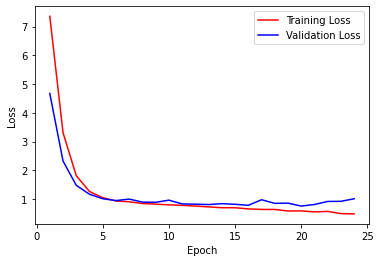

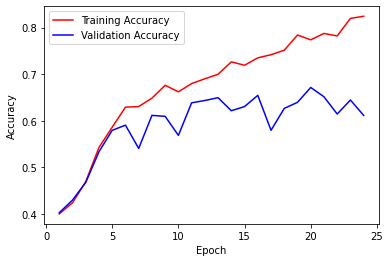

In [71]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'r-')
plt.plot(epochs, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, history.history['accuracy'], 'r-')
plt.plot(epochs, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Testing

In [0]:
# OPTIONAL: Load presaved model instead of using a newly trained one

from keras.models import load_model
# Uncomment these lines to use this code:
#del model
model = load_model('gdrive/My Drive/ML Project/Sentiment_CNN_V1.h5')

In [74]:
# evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

1002/1002 [==============================] - 3s 3ms/step
Test Accuracy: 70.658684


In [0]:
# Saves the current model.
# WARNING: This will overwrite existing saved model,
# unless you change the filename!

# Uncomment this line to use this code:
#model.save('gdrive/My Drive/ML Project/Sentiment_CNN.h5')

## Model Visualization

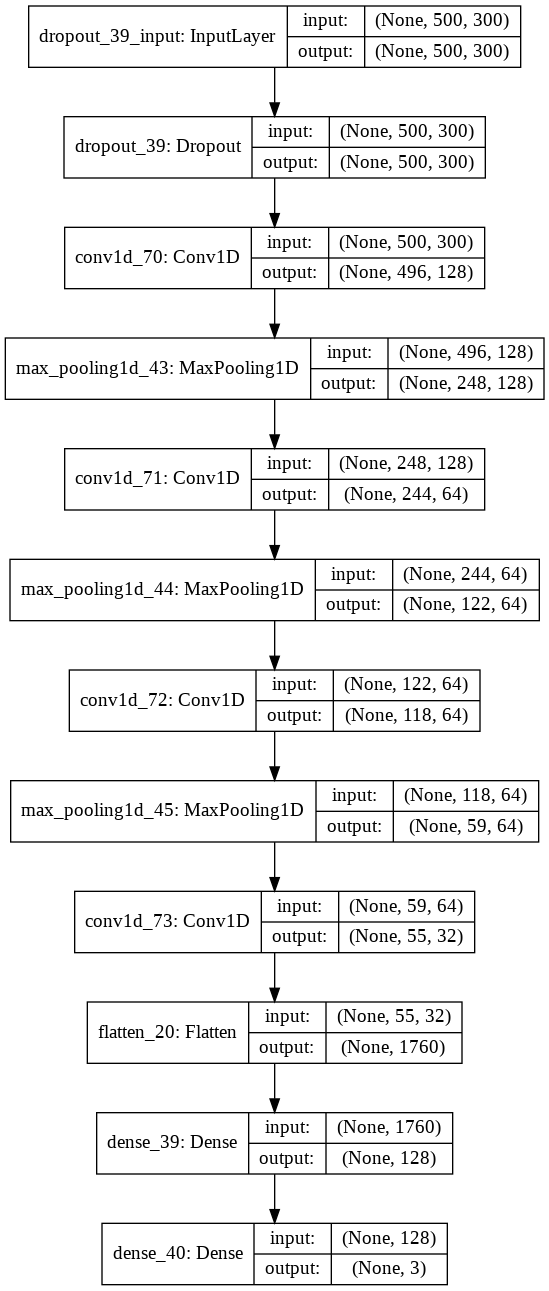

In [75]:
from keras.utils import plot_model
plot_model(model, to_file='gdrive/My Drive/ML Project/model.png', show_shapes=True)